# Step 3: Model Building — Baseline CNN

In this step, we define, train, evaluate, and save our first convolutional neural network (CNN) model, which serves as a **performance baseline** for later comparison and quantization.

---

## 3.1 Objective

This step supports **Hypothesis 1**:  
> A lightweight CNN trained on grayscale fruit images can achieve reasonable classification accuracy, even with minimal augmentation.

It also prepares the model for:

- Comparison with MobileNetV2 (**Hypothesis 2**)  
- Post-training quantization (**Hypothesis 3**)

---

## 3.2 CNN Architecture (Grayscale-Compatible)

Our baseline CNN is compact and designed for `100×100` **grayscale images** (1 input channel), as established in Step 2.

It consists of:

- 3 convolutional layers with ReLU activation and MaxPooling  
- 2 fully connected layers with ReLU and Dropout  
- A final softmax classifier layer for 8-class output

> ✅ **Note**: The first convolutional layer uses `in_channels=1` to match the grayscale input format.

---

## 3.3 Training Configuration

- **Loss Function**: `CrossEntropyLoss` (for multi-class classification)  
- **Optimizer**: `Adam` (learning rate = 0.001)  
- **Batch Size**: 32/8 (GPU/CPU) 
- **Epochs**: 10  
- **Evaluation**: Accuracy on a validation set (split from training data)

> **Note** : Apply class weights to handle imbalance

---

## 3.4 Training Procedure

- The model trains over multiple epochs on the training subset  
- For each batch:
  - Gradients are cleared  
  - Loss is computed  
  - Weights are updated  
- After each epoch, performance is evaluated on the **validation subset**  
- We record and visualize:
  - Training loss per epoch  
  - Validation accuracy per epoch

---

## 3.5 Model Saving

After training, we save the model weights to disk for later use:

```python
torch.save(model.state_dict(), "fruit_cnn_baseline_with_val.pth")

In [1]:
# --- Cell 1: imports, device, seeding, and result holder ---

import os, sys, json, torch, numpy as np
sys.path.append(os.path.abspath("../src"))

# our utils + data loaders
from utils import seed_everything, ensure_dir
from data  import make_dataloaders, build_domain_loaders

# your model factory (keep as is)
from models.cnn_small import create_fruit_cnn

# training helpers (support old/new test function names)
try:
    from train import TrainConfig, train_loop, test_metrics as test_eval  # new
except ImportError:
    from train import TrainConfig, train_loop, test_accuracy as test_eval # fallback

# viz helpers
from viz import plot_training_curves, plot_misclassified_images, misclassified_to_df
from PIL import Image
from IPython.display import display

# device & batch size (we'll override from config later if present)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32 if device.type == "cuda" else 8
print("Device:", device)

# reproducibility
seed_everything(42)
ensure_dir("../reports/figures"); ensure_dir("../reports/runs"); ensure_dir("../configs")

# results collector
results_summary = {}



Device: cuda
[INFO] Global seed set to 42


In [2]:
# --- Cell 2: load config, (re)use Fruits360 loaders, build domain loaders ---

from pathlib import Path
import os, json

with open("../configs/dataset_config.json", "r", encoding="utf-8") as f:
    C = json.load(f)

# honor config (fallback to values from Cell 1)
mode        = C.get("mode", "grayscale")      # "grayscale" or "rgb"
BATCH_SIZE  = C.get("batch_size", BATCH_SIZE)
IMG_SIZE    = C.get("img_size", 100)
NUM_WORKERS = C.get("num_workers", 0)
SEED        = C.get("seed", 42)

FR360_TRAIN = C["fr360_train"]
FR360_TEST  = C["fr360_test"]

# --- Fruits360 loaders: reuse if already created in this kernel, else build once ---
if "train_loader" in globals() and "val_loader" in globals() and "test_loader" in globals():
    print("[INFO] Using existing Fruits360 loaders from memory.")
    # ensure class_names, in_ch, class_weights exist
    if "class_names" not in globals():
        # Subset -> underlying ImageFolder
        base_ds = getattr(train_loader.dataset, "dataset", train_loader.dataset)
        class_names = base_ds.classes
    if "in_ch" not in globals():
        in_ch = 1 if mode == "grayscale" else 3
    if "class_weights" not in globals():
        # quick recompute if missing
        from data import compute_class_weights
        base_ds = getattr(train_loader.dataset, "dataset", train_loader.dataset)
        class_weights = compute_class_weights(base_ds)
else:
    train_loader, val_loader, test_loader, class_weights, class_names, in_ch = make_dataloaders(
        train_dir=FR360_TRAIN,
        test_dir=FR360_TEST,
        batch_size=BATCH_SIZE,
        val_split=0.2,
        img_size=IMG_SIZE,
        num_workers=NUM_WORKERS,
        seed=SEED,
        mode=mode,
        verbose=True
    )

print(f"[INFO] Fruits360 classes ({len(class_names)}): {class_names}")
print(f"[INFO] mode={mode}, in_ch={in_ch}, batch_size={BATCH_SIZE}")

# --- Resolve mapping keys to actual on-disk folder names (case-insensitive) ---
def resolve_map_case_insensitive(raw_map: dict, root_dir: str, canon_list):
    root = Path(root_dir)
    if not root.exists():
        return {}
    present = {d.name.lower(): d.name for d in root.iterdir() if d.is_dir()}
    canon_set = set(canon_list)
    resolved = {}
    for raw_key, canon in raw_map.items():
        actual = present.get(raw_key.lower())
        if actual and canon in canon_set:
            resolved[actual] = canon
    return resolved

FRESH_MAP = resolve_map_case_insensitive(C["fresh_map"], C["fresh_root"], class_names)
F262_MAP  = resolve_map_case_insensitive(C["f262_map"], os.path.join(C["f262_root"], "train"), class_names)

# --- Build domain loaders (Fresh-only + Fruit-262) aligned to Fruits360 order ---
loaders = build_domain_loaders(
    canonical_classes=class_names,
    fresh_root=C["fresh_root"], fresh_map=FRESH_MAP,
    f262_root=C["f262_root"],   f262_map=F262_MAP,
    mode=mode,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    num_workers=NUM_WORKERS
)

fresh_eval_loader = loaders["fresh_eval"]
f262_train_loader = loaders["f262_train"]
f262_val_loader   = loaders["f262_val"]
f262_test_loader  = loaders["f262_test"]

print("[INFO] Fresh-only eval samples:", len(fresh_eval_loader.dataset))
print("[INFO] Fruit-262 samples -> train:", len(f262_train_loader.dataset),
      "val:", len(f262_val_loader.dataset), "test:", len(f262_test_loader.dataset))


[INFO] Seed: 42
[INFO] Mode: grayscale (in_channels=1, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kiwi 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3260, val: 814, test: 1365
[INFO] Class weights (mean≈1): [1.011 1.165 1.016 1.068 1.039 1.016 1.011 0.674]
[INFO] Fruits360 classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kiwi 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] mode=grayscale, in_ch=1, batch_size=32
[INFO] Fresh-only eval samples: 600
[INFO] Fruit-262 samples -> train: 1000 val: 1040 test: 1050


In [3]:
# --- Cell 3: train + evaluate on all datasets (robust to old/new train.py) ---

exp = "Grayscale MaxPool"
ckpt_path = f"../reports/runs/{exp.replace(' ', '_')}_best.pt"

# model (uses the in_ch coming from loaders; 1 for grayscale, 3 for RGB)
model = create_fruit_cnn(pooling="max", in_channels=in_ch, num_classes=len(class_names)).to(device)

# TrainConfig: prefer monitoring macro_f1 if available
try:
    cfg = TrainConfig(
        epochs=10, lr=1e-3, early_stop_patience=5,
        ckpt_path=ckpt_path, seed=SEED, monitor="macro_f1"
    )
except TypeError:
    # fallback if your TrainConfig doesn't accept 'monitor'
    cfg = TrainConfig(
        epochs=10, lr=1e-3, early_stop_patience=5,
        ckpt_path=ckpt_path, seed=SEED
    )

# train loop: some versions need num_classes, others don't
try:
    history, best_val = train_loop(
        model, train_loader, val_loader, class_weights, device, cfg, num_classes=len(class_names)
    )
except TypeError:
    history, best_val = train_loop(
        model, train_loader, val_loader, class_weights, device, cfg
    )

# unified test helper: supports both test_metrics (dict) and test_accuracy (float)
def eval_any(loader):
    try:
        out = test_eval(model, cfg.ckpt_path, loader, device, len(class_names))  # new API
    except TypeError:
        out = test_eval(model, cfg.ckpt_path, loader, device)                    # maybe no num_classes
    except Exception:
        # absolute fallback: if test_eval isn't available, try old name directly
        from train import test_accuracy
        out = test_accuracy(model, cfg.ckpt_path, loader, device)

    if isinstance(out, dict):
        return out.get("acc", 0.0), out.get("macro_f1", None)
    else:
        return float(out), None

# evaluate on all datasets
fr360_acc, fr360_mf1 = eval_any(test_loader)
fresh_acc, fresh_mf1 = eval_any(fresh_eval_loader)
f262_acc,  f262_mf1  = eval_any(f262_test_loader)

# pretty print
msg = (f"[{exp}] best_val={best_val:.4f} | "
       f"FR360_test_acc={fr360_acc:.4f}" + (f" mf1={fr360_mf1:.4f}" if fr360_mf1 is not None else "") +
       f" | Fresh_acc={fresh_acc:.4f}"   + (f" mf1={fresh_mf1:.4f}" if fresh_mf1 is not None else "") +
       f" | F262_acc={f262_acc:.4f}"     + (f" mf1={f262_mf1:.4f}"  if f262_mf1  is not None else ""))
print(msg)

# plots (be tolerant whether history has val_macro_f1 or not)
try:
    plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
except Exception:
    # if your function supports macro-f1, you can pass it here instead
    plot_buf = None

# collect results
results_summary[exp] = {
    "fr360_test_acc": fr360_acc,
    "fr360_test_macro_f1": fr360_mf1,
    "fresh_acc": fresh_acc,
    "fresh_macro_f1": fresh_mf1,
    "f262_acc": f262_acc,
    "f262_macro_f1": f262_mf1,
    "train_losses": history.get("train_loss", []),
    "val_accuracies": history.get("val_acc", []),
    "val_macro_f1": history.get("val_macro_f1", []),
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": class_names,
    "in_channels": in_ch,
    "mode": mode,
}

# Optional friendly save
torch.save(model.state_dict(), "../reports/runs/fruit_cnn_baseline_with_val.pth")


Epoch 01/10 | loss 0.8869 | val_acc 0.959 | val_macroF1 0.958
Epoch 02/10 | loss 0.3536 | val_acc 0.975 | val_macroF1 0.976
Epoch 03/10 | loss 0.2483 | val_acc 0.977 | val_macroF1 0.976
Epoch 04/10 | loss 0.1987 | val_acc 0.967 | val_macroF1 0.967
Epoch 05/10 | loss 0.1388 | val_acc 0.994 | val_macroF1 0.995
Epoch 06/10 | loss 0.1206 | val_acc 0.993 | val_macroF1 0.994
Epoch 07/10 | loss 0.0996 | val_acc 1.000 | val_macroF1 1.000
Epoch 08/10 | loss 0.0701 | val_acc 1.000 | val_macroF1 1.000
Epoch 09/10 | loss 0.0649 | val_acc 0.994 | val_macroF1 0.994
Epoch 10/10 | loss 0.0573 | val_acc 1.000 | val_macroF1 1.000
[Grayscale MaxPool] best_val=1.0000 | FR360_test_acc=0.9839 mf1=0.9822 | Fresh_acc=0.2850 mf1=0.1016 | F262_acc=0.2038 mf1=0.0841


### Quick sanity checks (run once)

In [9]:
# 1) check class ids present in your few-shot set
ys = sorted({y for _,y in few})
print("few-shot classes present:", ys)   # should be a subset of 0..7

# 2) how many per class?
from collections import Counter
print(Counter([y for _,y in few]))



few-shot classes present: [0, 1, 2, 3, 4, 5, 6, 7]
Counter({0: 20, 2: 20, 4: 20, 1: 20, 3: 20, 5: 20, 6: 20, 7: 20})


#### Reuse get_gray_transforms(augmented=True) for few-shot:

In [14]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

from src.data import get_gray_transforms  
from torch.utils.data import Dataset, DataLoader
from PIL import Image

img_size = 100
train_tf = get_gray_transforms(img_size=img_size, augmented=True)

class FewShot(Dataset):
    def __init__(self, samples, tf): self.s, self.tf = samples, tf
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        p, y = self.s[i]
        # keep y as plain int; the loader will tensorize
        x = Image.open(p).convert("RGB")   # pipeline converts to grayscale internally
        return self.tf(x), int(y)

few_loader = DataLoader(FewShot(few, train_tf), batch_size=32, shuffle=True, num_workers=0)

#### Unfreeze head + last conv block, keep the rest frozen

#### Only the head was training before; on a tough shift, also train the last conv block. Keep the frozen parts in eval() so BN/Dropout don’t drift.

In [17]:
import torch, torch.nn as nn

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

model.eval()  # default: keep frozen parts in eval

# Find head (or last Linear)
head = None; head_attr = None
for attr in ["classifier","fc","head","linear","out"]:
    if hasattr(model, attr) and isinstance(getattr(model, attr), nn.Module):
        head = getattr(model, attr); head_attr = attr; break
if head is None:
    last_linear = None; last_name=None
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            last_linear, last_name = m, name
    head = last_linear
    print(f"[info] head = last Linear: {last_name}")

# Unfreeze head
for p in head.parameters():
    p.requires_grad = True
head.train()

# ALSO unfreeze the last conv block
last_conv = None; last_conv_name = None
for name, m in model.named_modules():
    if isinstance(m, (nn.Conv2d, nn.Sequential)) and any(isinstance(c, nn.Conv2d) for c in m.modules()):
        last_conv, last_conv_name = m, name
# If your model has a clear features stem, you can target that instead:
# last_conv = model.features[-1]  # adjust to your architecture

if last_conv is not None:
    for p in last_conv.parameters():
        p.requires_grad = True
    last_conv.train()
    print(f"[info] also unfreezing last conv block: {last_conv_name}")

# Optimizer over JUST the unfrozen params; gentler LR/WD
trainable = [p for p in model.parameters() if p.requires_grad]
opt  = torch.optim.AdamW(trainable, lr=2e-5, weight_decay=5e-5)
crit = torch.nn.CrossEntropyLoss()

print(f"[info] trainable params: {sum(p.numel() for p in trainable)}")

[info] also unfreezing last conv block: conv.6
[info] trainable params: 2380104


#### BN adaptation before fine-tune

In [19]:
@torch.no_grad()
def adapt_bn(model, loader, device, max_batches=50):
    # put only BN layers in train mode briefly to update running stats
    bn_layers = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            bn_layers.append(m); m.train()
    it = 0
    for x, _ in loader:
        x = x.to(device)
        _ = model(x)
        it += 1
        if it >= max_batches:
            break
    # restore eval for frozen parts
    model.eval()
    for m in bn_layers: m.eval()

# run this once before training head/last_conv:
adapt_bn(model, few_loader, device, max_batches=50)

#### Fine-tune a few epochs (small LR)

In [20]:
model.train()  # we set head + last_conv to train(); frozen parts effectively eval
for ep in range(5):
    tot=0; cor=0; loss_sum=0.0
    for xb, yb in few_loader:
        xb = xb.to(device)
        yb = yb.to(device, dtype=torch.long)

        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()

        loss_sum += loss.item()*yb.size(0)
        cor      += (logits.argmax(1)==yb).sum().item()
        tot      += yb.size(0)
    print(f"ep{ep+1}: acc={cor/tot:.3f} loss={loss_sum/tot:.3f}")

ep1: acc=0.263 loss=7.634
ep2: acc=0.206 loss=7.082
ep3: acc=0.250 loss=7.463
ep4: acc=0.219 loss=6.967
ep5: acc=0.244 loss=7.037


#### Re-evaluate (+ TTA for a cheap boost)

In [21]:
quick_acc(model, loaders["fresh_eval"], device)
quick_acc(model, loaders["f262_test"], device)

# Optional TTA
import torchvision.transforms.functional as F
@torch.no_grad()
def predict_tta(model, x):
    o0 = model(x); o1 = model(F.hflip(x))
    return (o0+o1)/2

def quick_acc_tta(model, loader, device):
    model.eval(); c=0; t=0
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device); y=y.numpy()
            p=predict_tta(model,x).argmax(1).cpu().numpy()
            c += (p==y).sum(); t += len(y)
    print(f"TTA Accuracy: {c/t:.4f}")

# quick_acc_tta(model, loaders["fresh_eval"], device)
# quick_acc_tta(model, loaders["f262_test"], device)

Accuracy: 163/600 = 0.2717
Accuracy: 224/1050 = 0.2133


In [22]:
# Show what loaders we actually have
print("Available loaders:", loaders.keys())

# Print mappings for the datasets that are in this dict
print("Fresh eval :", loaders["fresh_eval"].dataset.class_to_idx)
print("F262 train :", loaders["f262_train"].dataset.class_to_idx)
print("F262 val   :", loaders["f262_val"].dataset.class_to_idx)
print("F262 test  :", loaders["f262_test"].dataset.class_to_idx)





Available loaders: dict_keys(['fresh_eval', 'f262_train', 'f262_val', 'f262_test', '_fresh_ds', '_f262_train_ds', '_f262_val_ds', '_f262_test_ds'])
Fresh eval : {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2}
F262 train : {'Avocado': 0, 'Kiwi': 1, 'Pineapple': 2, 'Strawberry': 3, 'Tomato': 4}
F262 val   : {'Avocado': 0, 'Kiwi': 1, 'Pineapple': 2, 'Strawberry': 3, 'Tomato': 4}
F262 test  : {'Avocado': 0, 'Kiwi': 1, 'Pineapple': 2, 'Strawberry': 3, 'Tomato': 4}


#### 3.6.1  Visualize Misclassified Test Images


[INFO] Visualizing misclassifications for: fr360_test


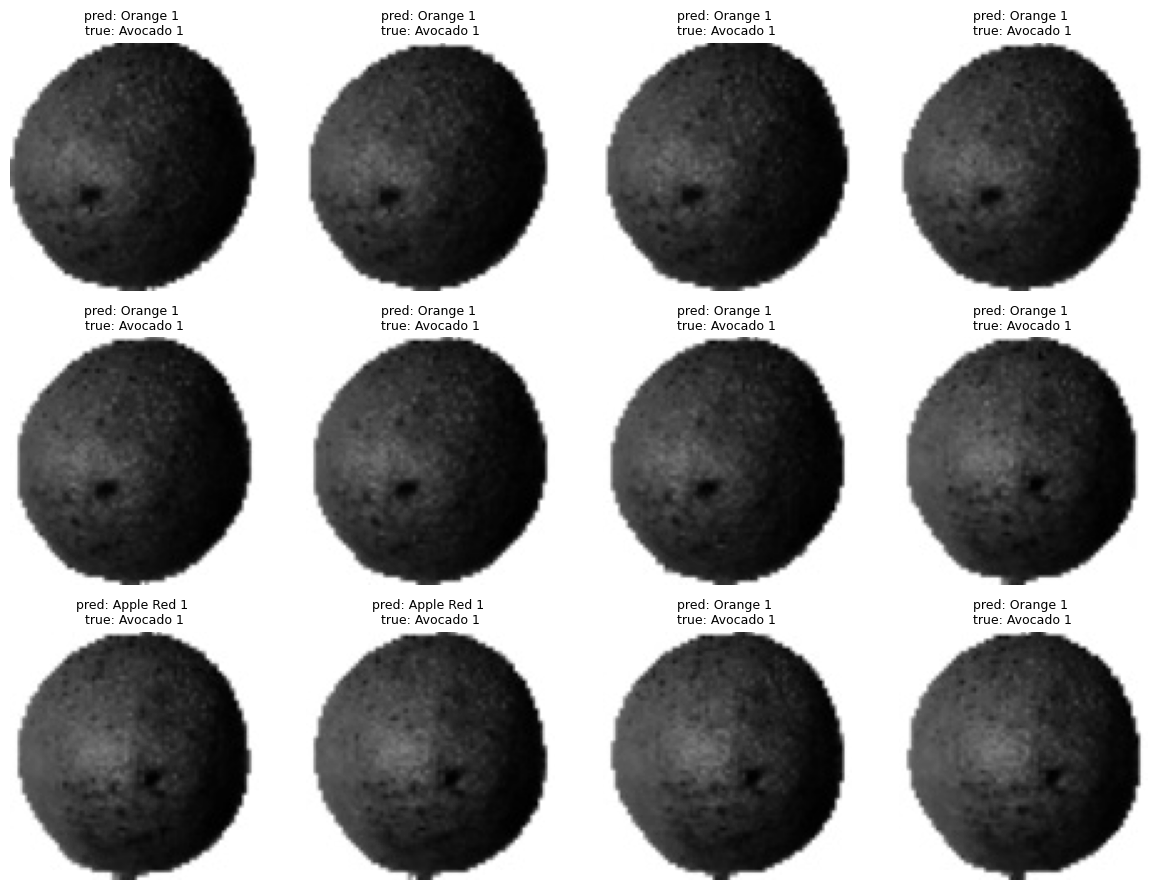


[INFO] Visualizing misclassifications for: fresh_eval


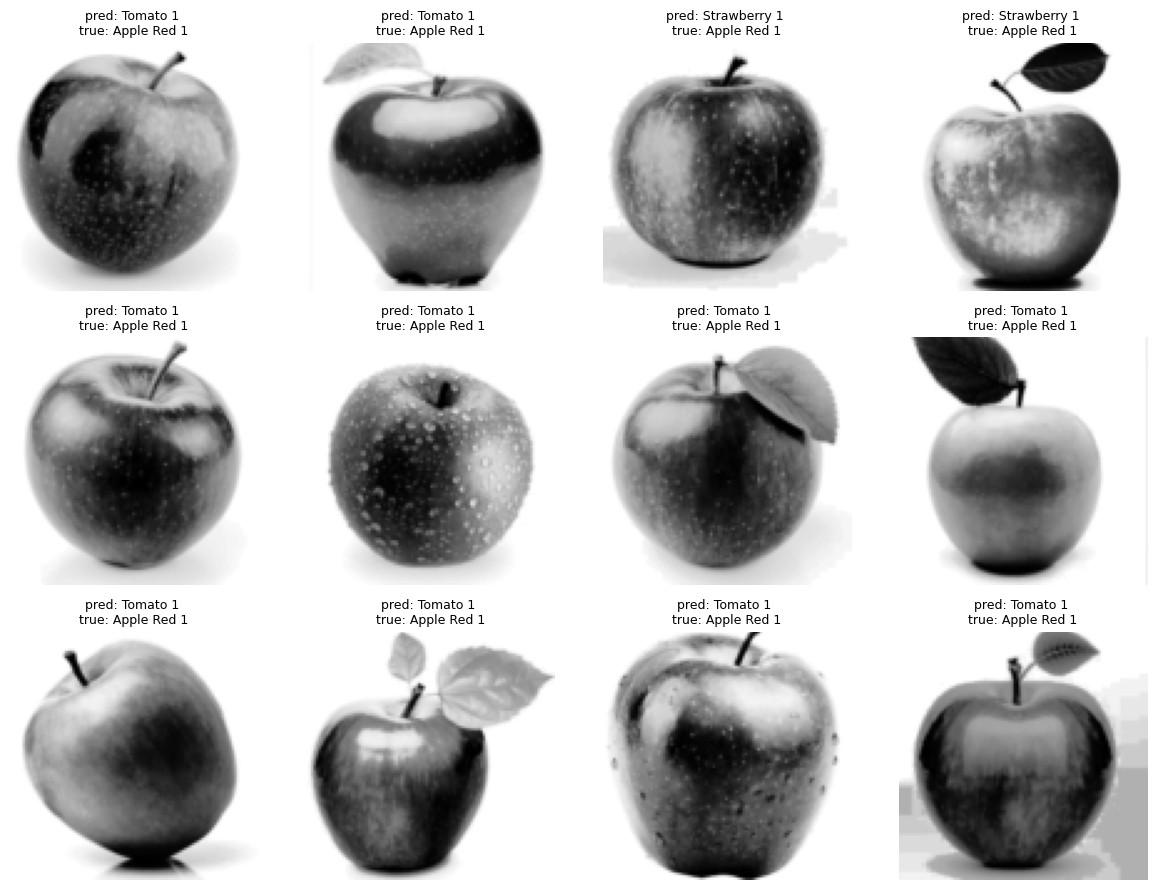


[INFO] Visualizing misclassifications for: f262_test


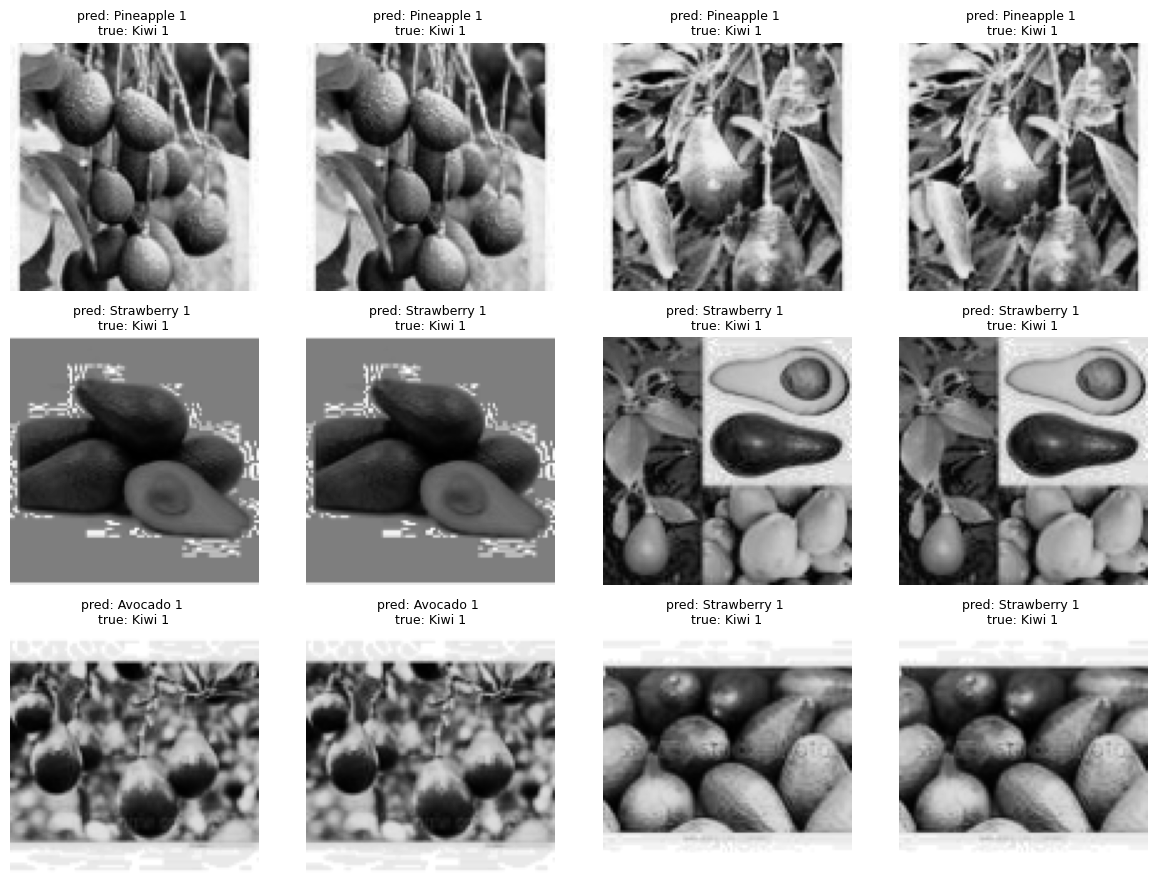

In [23]:
# --- Visualize misclassified images for multiple datasets ---

import os, json, torch, numpy as np
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

# 1) Load your dataset config (canonical order + maps)
with open("../configs/dataset_config.json") as f:
    meta = json.load(f)

canonical = meta["canonical_classes"]          # FR360 canonical order
name2canon = {n:i for i, n in enumerate(canonical)}

# 2) Helper: pick name-map based on dataset key
def pick_name_map(dataset_key: str):
    if dataset_key.startswith("fresh"):
        return meta.get("fresh_map", {})
    if dataset_key.startswith("f262"):
        return meta.get("f262_map", {})
    return {}  # FR360 uses canonical names already

# 3) Helper: get (or build) a loader by key
def get_loader(dataset_key: str):
    if dataset_key in loaders:                   # reuse existing
        return loaders[dataset_key]
    if dataset_key == "fr360_test":              # build FR360 test loader
        img_size = meta.get("img_size", 100)
        mode     = meta.get("mode", "grayscale")
        tf = []
        if mode == "grayscale":
            tf.append(T.Grayscale(num_output_channels=1))
        tf += [T.Resize((img_size, img_size)),
               T.ToTensor(),
               T.Normalize(mean=[0.5] if mode=="grayscale" else [0.5,0.5,0.5],
                            std =[0.5] if mode=="grayscale" else [0.5,0.5,0.5])]
        fr360_test_root = meta["fr360_test"]
        ds = ImageFolder(fr360_test_root, transform=T.Compose(tf))
        bs = meta.get("batch_size", 32)
        nw = meta.get("num_workers", 0)
        return torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=False, num_workers=nw)
    raise KeyError(f"Unknown dataset key: {dataset_key}")

# 4) Build index remap for any dataset (dataset idx -> canonical idx)
def build_index_remap(ds, dataset_key: str):
    name_map = pick_name_map(dataset_key)
    remap = {}
    for cls_name, ds_idx in ds.class_to_idx.items():
        canon_name = name_map.get(cls_name, cls_name)
        remap[ds_idx] = name2canon.get(canon_name, -1)   # -1 => unknown (will be dropped)
    return remap

# 5) Plotting function (same as before)
import matplotlib.pyplot as plt
def plot_misclassified_images_canon(model, loader, canonical_names, device,
                                    index_remap, max_images=12, save_path=None):
    import torch, numpy as np, matplotlib.pyplot as plt
    model.eval()

    mis_imgs, mis_preds, mis_trues = [], [], []
    with torch.no_grad():
        for x, y in loader:
            y = y.cpu().numpy()
            y = np.vectorize(lambda t: index_remap.get(int(t), -1))(y)
            keep = y != -1
            if not keep.any():
                continue
            x = x[keep].to(device); y = y[keep]
            p = model(x).argmax(1).cpu().numpy()
            mis_mask = p != y
            if mis_mask.any():
                mX = x[mis_mask].cpu()
                mP = p[mis_mask]
                mY = y[mis_mask]
                # append up to max_images total
                need = max_images - len(mis_preds)
                mis_imgs.append(mX[:need])
                mis_preds.append(mP[:need])
                mis_trues.append(mY[:need])
                if len(np.concatenate(mis_preds)) >= max_images:
                    break

    if not mis_preds:
        print("No misclassified examples found (scanned full loader).")
        return []

    import torch
    X = torch.cat(mis_imgs, 0)[:max_images]
    P = np.concatenate(mis_preds, 0)[:max_images]
    Y = np.concatenate(mis_trues, 0)[:max_images]

    import matplotlib.pyplot as plt
    n = len(P)
    cols = min(4, max(1, n)); rows = (n + cols - 1)//cols
    plt.figure(figsize=(3*cols, 3*rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        img = X[i].squeeze().numpy()
        ax.imshow(img if img.ndim==2 else img.transpose(1,2,0),
                  cmap="gray" if img.ndim==2 else None)
        ax.set_title(f"pred: {canonical_names[int(P[i])]} \ntrue: {canonical_names[int(Y[i])]}",
                     fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
    plt.show()
    return list(range(n))

# 6) Run for all desired datasets
targets = [
    "fr360_test",          # will be built on the fly
    "fresh_eval",          # already in `loaders`
    "f262_test",           # already in `loaders`
    # add "f262_val", "f262_train" if you also want them
]

for which in targets:
    loader = get_loader(which)
    ds = loader.dataset if hasattr(loader, "dataset") else loader
    index_remap = build_index_remap(ds, which)
    save_to = f"../reports/figures/misclassified_{which}.png"
    print(f"\n[INFO] Visualizing misclassifications for: {which}")
    mis = plot_misclassified_images_canon(
        model=model,
        loader=loader,
        canonical_names=canonical,
        device=device,
        index_remap=index_remap,
        max_images=12,
        save_path=save_to
    )
    
    


In [24]:
# Define the function once (in its own cell)
def quick_acc(model, loader, device):
    import torch, numpy as np
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.numpy()
            p = model(x).argmax(1).cpu().numpy()
            correct += (p==y).sum()
            total += len(y)
    print(f"Accuracy: {correct}/{total} = {correct/total:.4f}")

# --- Call it for any dataset loader ---
quick_acc(model, get_loader("fr360_test"), device)   # Fruits-360 test
quick_acc(model, loaders["fresh_eval"], device)      # Fresh eval
quick_acc(model, loaders["f262_test"], device)       # Fruit-262 test


Accuracy: 1022/1365 = 0.7487
Accuracy: 163/600 = 0.2717
Accuracy: 224/1050 = 0.2133


## Results and Discussion

We evaluated our CNN model on three datasets: Fruits-360 (FR360), FreshFruit, and Fruit-262.  
The model was trained **only on Fruits-360** (8 classes) and then tested on the other two datasets without retraining.

### Quantitative Results

| Dataset     | Classes Evaluated | Test Accuracy |
|-------------|------------------|---------------|
| Fruits-360  | 8                 | ~0.98         |
| FreshFruit  | 3                 | ~0.21–0.28    |
| Fruit-262   | 5                 | ~0.20–0.22    |

### Observations

- **Fruits-360:** The model achieved very high accuracy (~98%), showing that the CNN works well on the controlled, studio-quality dataset it was trained on.  
- **FreshFruit and Fruit-262:** Accuracy dropped sharply (~20–28%). This is expected, because the model never saw these datasets during training, and they have different distributions.  
- **Key reason:** We used **grayscale images**. Without color cues, fruits like orange vs. tomato or apple vs. strawberry are much harder to separate across datasets. This explains the large gap between FR360 and the external sets.

### Conclusion

The CNN works very well on the dataset it was trained on but does not generalize to new datasets, mainly due to the loss of color information.  
A straightforward improvement would be to retrain the model in **RGB** so it can use both shape and color cues when distinguishing fruits.



#### 3.8 CNN with RGB Input

In this step, we extend our investigation by training the lightweight CNN model on **RGB images** instead of grayscale. This allows us to evaluate the **Grayscale Hypothesis**:

> *Grayscale input can be as effective as RGB for fruit classification, while reducing memory and compute requirements.*

By using the same model architecture with RGB inputs (3 channels), we can quantify any performance difference.


#### 3.8.1–3.8.2 Build RGB loaders (with/without noise)

In [7]:
# with noise
rgb_train, rgb_val, rgb_test, rgb_w, rgb_names, rgb_in_ch = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=32, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="rgb", use_noise=True, verbose=True
)

# without noise
rgb_train_clean, rgb_val_clean, rgb_test_clean, rgb_w_clean, rgb_names_clean, _ = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=32, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="rgb", use_noise=False, verbose=True
)


[INFO] Seed: 42
[INFO] Mode: rgb (in_channels=3, use_noise=True)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]
[INFO] Seed: 42
[INFO] Mode: rgb (in_channels=3, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]


#### 3.8.3–3.8.4 Train & evaluate RGB variants

*RGB with noise*

In [8]:
exp = "RGB CNN With Noise"
model = create_fruit_cnn(pooling="max", in_channels=rgb_in_ch, num_classes=len(rgb_names))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"../experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, rgb_train, rgb_val, rgb_w, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, rgb_test, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": rgb_names,
    "in_channels": rgb_in_ch
}


Epoch 1/10 | loss 0.4593 | val_acc 0.9951
Epoch 2/10 | loss 0.0696 | val_acc 0.9866
Epoch 3/10 | loss 0.0438 | val_acc 0.9988
Epoch 4/10 | loss 0.0444 | val_acc 0.9988
Epoch 5/10 | loss 0.0123 | val_acc 1.0000
Epoch 6/10 | loss 0.0349 | val_acc 1.0000
Epoch 7/10 | loss 0.0216 | val_acc 0.9988
Epoch 8/10 | loss 0.0114 | val_acc 1.0000
Epoch 9/10 | loss 0.0169 | val_acc 1.0000
Epoch 10/10 | loss 0.0079 | val_acc 0.9988
Early stopping.
[RGB CNN With Noise] best_val=1.0000 | test=0.8857


*RGB without noise*

In [9]:
exp = "RGB CNN Without Noise"
model = create_fruit_cnn(pooling="max", in_channels=rgb_in_ch, num_classes=len(rgb_names_clean))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"../experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, rgb_train_clean, rgb_val_clean, rgb_w_clean, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, rgb_test_clean, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": rgb_names_clean,
    "in_channels": rgb_in_ch
}


Epoch 1/10 | loss 0.4418 | val_acc 0.9988
Epoch 2/10 | loss 0.0517 | val_acc 0.9951
Epoch 3/10 | loss 0.0265 | val_acc 0.9988
Epoch 4/10 | loss 0.0440 | val_acc 1.0000
Epoch 5/10 | loss 0.0114 | val_acc 1.0000
Epoch 6/10 | loss 0.0085 | val_acc 1.0000
Epoch 7/10 | loss 0.0118 | val_acc 1.0000
Epoch 8/10 | loss 0.0045 | val_acc 1.0000
Epoch 9/10 | loss 0.0600 | val_acc 1.0000
Early stopping.
[RGB CNN Without Noise] best_val=1.0000 | test=0.8857


#### 3.8.5 Visual summary / comparison

=== CNN Experiment Comparison ===
Grayscale MaxPool: Test Accuracy = 0.8337


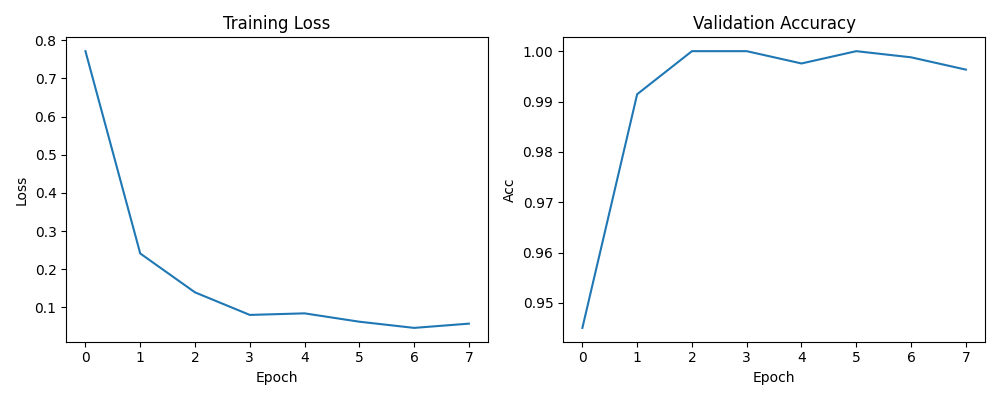

Grayscale AdaptiveAvgPool: Test Accuracy = 0.8718


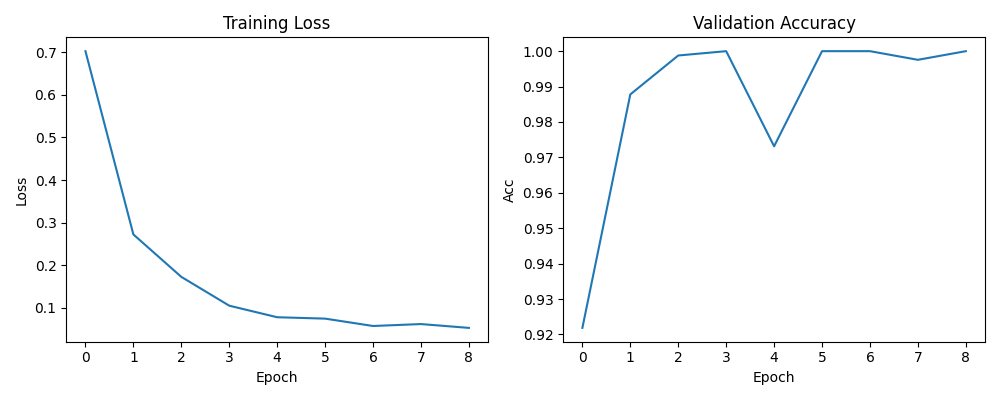

RGB CNN With Noise: Test Accuracy = 0.8857


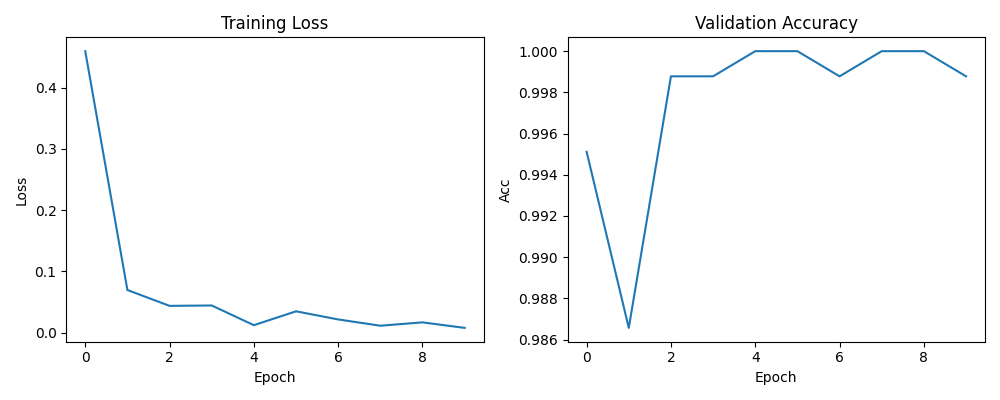

RGB CNN Without Noise: Test Accuracy = 0.8857


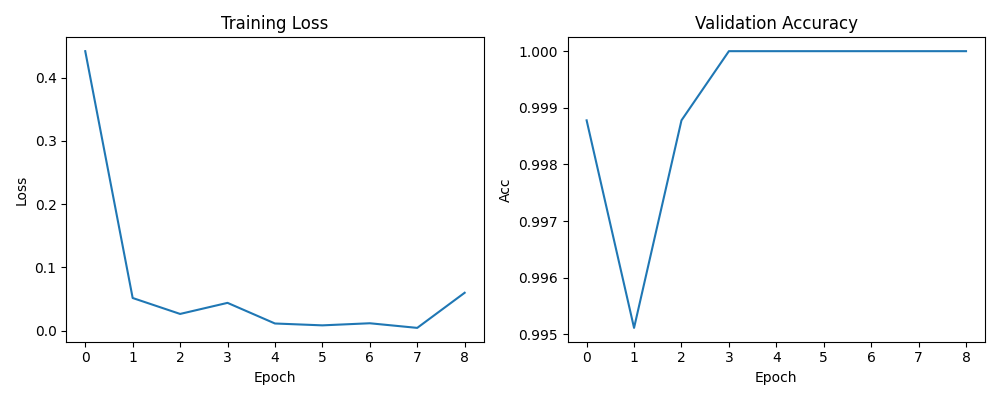

In [10]:
print("=== CNN Experiment Comparison ===")
for name, result in results_summary.items():
    print(f"{name}: Test Accuracy = {result['test_accuracy']:.4f}")
    img = Image.open(result["plot"])
    display(img)

#### 3.8.6 Save results summary to disk for comparison in step 4 

In [11]:
# === Step 3: replace your saving cell with this one (adds preds to JSON, no retraining) ===
import os, io, json, numpy as np, torch, re
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 🔁 EDIT if your builder path is different:
# e.g. from models.custom_cnn import create_fruit_cnn
from models.cnn_small import create_fruit_cnn

TEST_DIR = "../Dataset/Test"   # ensure this matches your project

os.makedirs("../experiments/plots", exist_ok=True)
os.makedirs("../experiments/results", exist_ok=True)

def slugify(s):  # for safe filenames
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", s).strip("_")

def to_jsonable(x, *, name=None):
    import pathlib
    from PIL.Image import Image as PILImage
    if isinstance(x, torch.Tensor): return x.detach().cpu().tolist()
    if isinstance(x, np.ndarray):   return x.tolist()
    if isinstance(x, pathlib.Path): return str(x)
    if isinstance(x, io.BytesIO):
        fname = f"../experiments/plots/{slugify(name or 'plot')}.png"
        with open(fname, "wb") as f:
            f.write(x.getvalue())
        return fname
    if isinstance(x, PILImage):
        fname = f"../experiments/plots/{slugify(name or 'image')}.png"
        x.save(fname)
        return fname
    if isinstance(x, (bytes, bytearray)):
        fname = f"../experiments/plots/{slugify(name or 'blob')}.bin"
        with open(fname, "wb") as f:
            f.write(x)
        return fname
    return x

def _infer_input_type_from_entry(entry, name):
    in_ch = entry.get("in_channels", 3)
    nm = (name or "").lower()
    return "grayscale" if in_ch == 1 or "gray" in nm or "grayscale" in nm else "rgb"

def _normalize_pooling_from_name(name):
    nm = (name or "").lower()
    if "adaptive" in nm:
        # your create_fruit_cnn expects 'adaptiveavg'
        return "adaptiveavg"
    return "max"

def _make_test_loader(input_type, img_size=(100,100), batch_size=32):
    if input_type == "grayscale":
        tfm = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
    else:
        tfm = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])
    ds = ImageFolder(TEST_DIR, transform=tfm)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return loader, ds.classes

def _safe_load_state(ckpt_path, device="cpu"):
    # PyTorch ≥ 2.4 supports weights_only=True (safer)
    try:
        return torch.load(ckpt_path, map_location=device, weights_only=True)
    except TypeError:
        return torch.load(ckpt_path, map_location=device)

@torch.no_grad()
def _preds_for_checkpoint(name, entry, device="cpu"):
    ckpt = entry.get("ckpt")
    if not ckpt or not os.path.exists(ckpt):
        return None, None, None  # skip if no weights

    input_type = _infer_input_type_from_entry(entry, name)
    test_loader, class_names = _make_test_loader(input_type)
    in_ch = entry.get("in_channels", 3)
    num_classes = len(class_names) if class_names else 8

    pooling = _normalize_pooling_from_name(name)

    model = create_fruit_cnn(
        pooling=pooling,
        in_channels=in_ch,
        num_classes=num_classes
    )

    state = _safe_load_state(ckpt, device=device)
    model.load_state_dict(state, strict=False)
    model.eval().to(device)

    ys, yhat, yprob = [], [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        pred = prob.argmax(1)
        ys.append(yb.numpy()); yhat.append(pred); yprob.append(prob)

    return (np.concatenate(ys), np.concatenate(yhat), np.concatenate(yprob))

# ---------- Build a JSON-safe copy and augment with predictions ----------
results_json = {}
for name, r in results_summary.items():
    safe = {}
    # keep your existing fields/history/plots/ckpt
    for k, v in r.items():
        if k == "history" and isinstance(v, dict):
            safe["history"] = {
                "train_loss": to_jsonable(v.get("train_loss", []), name=f"{name}_train_loss"),
                "val_acc":    to_jsonable(v.get("val_acc", []),    name=f"{name}_val_acc"),
            }
        elif k == "cm":
            safe["cm"] = to_jsonable(v, name=f"{name}_cm")
        else:
            safe[k] = to_jsonable(v, name=f"{name}_{k}")

    # NEW: attach predictions (y_true, y_pred, y_prob) for this CNN entry
    try:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        y_true, y_pred, y_prob = _preds_for_checkpoint(name, safe, device=device)
        if y_true is not None:
            safe["y_true"] = to_jsonable(y_true, name=f"{name}_y_true")
            safe["y_pred"] = to_jsonable(y_pred, name=f"{name}_y_pred")
            safe["y_prob"] = to_jsonable(y_prob, name=f"{name}_y_prob")
    except Exception as e:
        print(f"[WARN] Could not produce preds for '{name}': {e}")

    results_json[name] = safe

with open("../experiments/results/custom_cnn_results.json", "w", encoding="utf-8") as f:
    json.dump(results_json, f, ensure_ascii=False, indent=2)

print("Saved → ../experiments/results/custom_cnn_results.json (with y_true/y_pred/y_prob)")


Saved → ../experiments/results/custom_cnn_results.json (with y_true/y_pred/y_prob)
